In [ ]:
# Install dependencies
!pip install torch torchvision opencv-python pillow numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
import glob
from pathlib import Path
from collections import defaultdict
from google.colab import drive
import re

# Mount Google Drive
drive.mount('/content/drive' , force_remount=True)

Mounted at /content/drive


In [ ]:
import os
real_dir = '/content/drive/MyDrive/data/real_frames'
print(f"Checking directory: {real_dir}")
print(f"Directory exists: {os.path.exists(real_dir)}")
print(f"Files in directory: {os.listdir(real_dir)}")

In [ ]:
import os
import shutil
from google.colab import drive

# Ensure the mount point is empty before mounting
mountpoint = '/content/drive'

# Check if the mountpoint exists and is not empty
if os.path.exists(mountpoint) and os.path.isdir(mountpoint) and os.listdir(mountpoint):
    print(f"Mountpoint '{mountpoint}' is not empty. Attempting to clear...")
    try:
        # Use shell command for recursive removal, typically faster and more robust
        !rm -rf {mountpoint}/*
        print(f"Cleared contents of '{mountpoint}'.")
        # Recreate the directory if it was removed by rm -rf *
        os.makedirs(mountpoint, exist_ok=True)
    except Exception as e:
        print(f"Error clearing mountpoint '{mountpoint}': {e}")
        # If clearing fails, you might need manual intervention or skip mounting
        # For this case, we'll proceed with mounting, but be aware it might still fail
        pass # Or handle the error appropriately

# Now mount Google Drive
drive.mount(mountpoint , force_remount=True)

Mounted at /content/drive


In [ ]:
# === The New, Fast, and Space-Efficient Data Setup Script ===
# This version copies zips to a temp area and deletes each zip
# immediately after unzipping to manage disk space.

import os
import glob
import time
import shutil
from google.colab import drive

# --- Configuration ---
DRIVE_ZIPPED_DATA_DIR = "/content/drive/MyDrive/zipped"
LOCAL_DATASET_DIR = "/content/local_data"
# A dedicated temporary directory for the zip files
LOCAL_TEMP_ZIP_DIR = "/content/temp_zips"
# --- End of Configuration ---


# --- Main Logic ---
print("--- Starting Fast & Space-Efficient Data Setup ---")
start_time_total = time.time()
drive.mount('/content/drive', force_remount=True)

# Define the final local paths for each data type
local_real_dir = os.path.join(LOCAL_DATASET_DIR, "real_frames")
local_fake_dir = os.path.join(LOCAL_DATASET_DIR, "fake_frames")
local_flow_dir = os.path.join(LOCAL_DATASET_DIR, "precomputed_flow_features")

# Create the main local data directory and subdirectories
os.makedirs(local_real_dir, exist_ok=True)
os.makedirs(local_fake_dir, exist_ok=True)
os.makedirs(local_flow_dir, exist_ok=True)
# NEW: Create the dedicated temporary directory for zip files
os.makedirs(LOCAL_TEMP_ZIP_DIR, exist_ok=True)
print(f"Local data directories created at '{LOCAL_DATASET_DIR}'")


# --- Step 1: Copy all zipped chunks into the temporary local directory ---
print(f"\n--- Step 1: Copying all zip chunks from Drive to '{LOCAL_TEMP_ZIP_DIR}'... ---")
start_time_copy = time.time()

source_zip_pattern = os.path.join(DRIVE_ZIPPED_DATA_DIR, "*.zip")
zip_files_to_copy = glob.glob(source_zip_pattern)

if not zip_files_to_copy:
    print(f"❌ ERROR: No .zip files found using glob at '{source_zip_pattern}'. Please re-check the path.")
else:
    print(f"Found {len(zip_files_to_copy)} zip files to copy.")
    for source_path in zip_files_to_copy:
        # The destination is now the dedicated temp directory
        shutil.copy(source_path, LOCAL_TEMP_ZIP_DIR)

    end_time_copy = time.time()
    print(f"-> Copying all zips finished in {end_time_copy - start_time_copy:.2f} seconds.")


# --- Step 2: Unzip, Combine, and Incrementally Delete the Chunks ---
print("\n--- Step 2: Unzipping chunks and deleting zips to save space... ---")

# A) Process 'real_frames' chunks
# The glob pattern now looks inside the temp directory
real_zips = sorted(glob.glob(os.path.join(LOCAL_TEMP_ZIP_DIR, "real_frames_chunk_*.zip")))
if real_zips:
    print(f"  Unzipping {len(real_zips)} 'real_frames' chunks into '{local_real_dir}'...")
    for zip_file in real_zips:
        # Unzip the file
        !unzip -q -o "{zip_file}" -d "{local_real_dir}"
        # Immediately delete the zip file to free up space
        os.remove(zip_file)
        print(f"    - Unzipped and deleted {os.path.basename(zip_file)}")
else:
    print("  Warning: No 'real_frames' zip chunks found in temp directory.")

# B) Process 'fake_frames' chunks
fake_zips = sorted(glob.glob(os.path.join(LOCAL_TEMP_ZIP_DIR, "fake_frames_chunk_*.zip")))
if fake_zips:
    print(f"  Unzipping {len(fake_zips)} 'fake_frames' chunks into '{local_fake_dir}'...")
    for zip_file in fake_zips:
        !unzip -q -o "{zip_file}" -d "{local_fake_dir}"
        os.remove(zip_file)
        print(f"    - Unzipped and deleted {os.path.basename(zip_file)}")
else:
    print("  Warning: No 'fake_frames' zip chunks found in temp directory.")

# C) Process 'precomputed_flow' chunk
flow_zips = sorted(glob.glob(os.path.join(LOCAL_TEMP_ZIP_DIR, "Combined_Precomputed_Flow*.zip")))
if flow_zips:
    print(f"  Unzipping {len(flow_zips)} 'precomputed_flow' chunk(s) into '{local_flow_dir}'...")
    for zip_file in flow_zips:
        !unzip -q -o "{zip_file}" -d "{local_flow_dir}"
        os.remove(zip_file)
        print(f"    - Unzipped and deleted {os.path.basename(zip_file)}")
else:
    print("  Warning: No 'precomputed_flow' zips found in temp directory.")


# --- Step 3: Final Verification and Cleanup ---
print("\n--- Step 3: Verifying and cleaning up... ---")
try:
    num_real = len(os.listdir(local_real_dir))
    num_fake = len(os.listdir(local_fake_dir))
    num_flow = len(os.listdir(local_flow_dir))

    print(f"  Verification successful:")
    print(f"  - Real frames folder: {num_real} files")
    print(f"  - Fake frames folder: {num_fake} files")
    print(f"  - Flow features folder: {num_flow} files")
except FileNotFoundError as e:
    print(f"  Verification failed. A directory was not created correctly: {e}")

# Clean up the (now empty) temporary directory for the zips
print(f"  Cleaning up temporary directory: '{LOCAL_TEMP_ZIP_DIR}'...")
shutil.rmtree(LOCAL_TEMP_ZIP_DIR)

end_time_total = time.time()
print(f"\n✅ SUCCESS! Your dataset is ready for training in {end_time_total - start_time_total:.2f} seconds.")

--- Starting Fast & Space-Efficient Data Setup ---
Mounted at /content/drive
Local data directories created at '/content/local_data'

--- Step 1: Copying all zip chunks from Drive to '/content/temp_zips'... ---
Found 39 zip files to copy.
-> Copying all zips finished in 707.92 seconds.

--- Step 2: Unzipping chunks and deleting zips to save space... ---
  Unzipping 19 'real_frames' chunks into '/content/local_data/real_frames'...
    - Unzipped and deleted real_frames_chunk_01_000000-009999.zip
    - Unzipped and deleted real_frames_chunk_02_010000-019999.zip
    - Unzipped and deleted real_frames_chunk_03_020000-029999.zip
    - Unzipped and deleted real_frames_chunk_04_030000-039999.zip
    - Unzipped and deleted real_frames_chunk_05_040000-049999.zip
    - Unzipped and deleted real_frames_chunk_06_050000-059999.zip
    - Unzipped and deleted real_frames_chunk_07_060000-069999.zip
    - Unzipped and deleted real_frames_chunk_08_070000-079999.zip
    - Unzipped and deleted real_frames

Training

In [ ]:
import cv2
import numpy as np
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import glob
from collections import defaultdict
import random
import gc
import re
from PIL import Image
import time
import math

# --- Debug Flag ---
DEBUG_VERBOSE = False

# --- Global Configurations ---
# UPDATED to match your new data preprocessing
SEQUENCE_LENGTH = 30
FLOW_DIM = 2
NUM_CLASSES = 2

# --- PATHS (ASSUMING DATA IS ALREADY COPIED LOCALLY) ---
# INPUT: Pointing to your new directories with 60 frames per video
LOCAL_REAL_FRAMES_DIR = '/content/local_data/real_frames'
LOCAL_FAKE_FRAMES_DIR = '/content/local_data/fake_frames'
# INPUT: Pointing to your new flow directory for 30-frame sequences
PRECOMPUTED_FLOW_DIR_FOR_DATASET = '/content/local_data/precomputed_flow_features'

# --- Output Paths (on Google Drive) ---
DRIVE_OUTPUT_BASE = f'/content/drive/MyDrive/final_balanced_data/cnn_lstm{SEQUENCE_LENGTH}_output'
LOG_FILE_PATH = os.path.join(DRIVE_OUTPUT_BASE, 'training_log.txt')
BEST_MODEL_SAVE_PATH = os.path.join(DRIVE_OUTPUT_BASE, f'best_model.pth')
OUTPUT_DIR_FOR_PLOTS_AND_REPORTS = os.path.join(DRIVE_OUTPUT_BASE, 'reports_and_plots')
LATEST_CHECKPOINT_PATH = os.path.join(DRIVE_OUTPUT_BASE, 'latest_checkpoint.pth')


# Fallback local paths
LOCAL_OUTPUT_BASE_FALLBACK = f'/content/outputs_local_cnn_lstm_SL{SEQUENCE_LENGTH}'
_LOG_FILE_PATH_TEMP = os.path.join(LOCAL_OUTPUT_BASE_FALLBACK, 'training_log.txt')
_BEST_MODEL_SAVE_PATH_TEMP = os.path.join(LOCAL_OUTPUT_BASE_FALLBACK, f'best_model.pth')
_OUTPUT_DIR_FOR_PLOTS_AND_REPORTS_TEMP = os.path.join(LOCAL_OUTPUT_BASE_FALLBACK, 'reports_and_plots')

# --- Mount Drive and Setup Output Dirs ---
try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted for saving outputs.")
    os.makedirs(os.path.dirname(LOG_FILE_PATH), exist_ok=True)
    os.makedirs(os.path.dirname(BEST_MODEL_SAVE_PATH), exist_ok=True)
    os.makedirs(OUTPUT_DIR_FOR_PLOTS_AND_REPORTS, exist_ok=True)
    print(f"Output directories on Drive ensured/created at {DRIVE_OUTPUT_BASE}")
except Exception as e:
    print(f"Warning: Drive mount/setup error: {e}. Using local fallback for outputs.")
    DRIVE_OUTPUT_BASE = LOCAL_OUTPUT_BASE_FALLBACK
    LOG_FILE_PATH = _LOG_FILE_PATH_TEMP; BEST_MODEL_SAVE_PATH = _BEST_MODEL_SAVE_PATH_TEMP
    OUTPUT_DIR_FOR_PLOTS_AND_REPORTS = _OUTPUT_DIR_FOR_PLOTS_AND_REPORTS_TEMP
    for p_dir in [os.path.dirname(LOG_FILE_PATH), os.path.dirname(BEST_MODEL_SAVE_PATH), OUTPUT_DIR_FOR_PLOTS_AND_REPORTS]:
        os.makedirs(p_dir, exist_ok=True)
    print(f"Using LOCAL fallback paths for outputs: {DRIVE_OUTPUT_BASE}")

# --- DeepfakeFrameDataset Class (Corrected for Symmetric Flow Loading) ---
class DeepfakeFrameDataset(Dataset):
    def __init__(self, sequences_info_list, sequence_length=SEQUENCE_LENGTH, transform=None):
        self.sequence_length = sequence_length
        self.transform = transform
        self.sequences_info = [info for info in sequences_info_list if info is not None and info[0] is not None]

    def __len__(self):
        return len(self.sequences_info)

    def __getitem__(self, idx):
        if idx >= len(self.sequences_info):
            return None, None, None
        seq_paths, label, sequence_identifier = self.sequences_info[idx]
        if not isinstance(seq_paths, list) or len(seq_paths) != self.sequence_length:
            return None, None, None

        # --- Frame loading ---
        frames = []
        for path_str in seq_paths:
            try:
                img = Image.open(str(path_str)).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                frames.append(img)
            except:
                return None, None, None
        if len(frames) != self.sequence_length:
            return None, None, None
        frames_tensor = torch.stack(frames)

        # --- Flow loading ---
        flow_feature_filename = f"{sequence_identifier}_flow.pt"
        flow_feature_path = os.path.join(PRECOMPUTED_FLOW_DIR_FOR_DATASET, flow_feature_filename)

        flow_features_sequence = None
        try:
            loaded_flow = torch.load(flow_feature_path)
            if loaded_flow.shape == (self.sequence_length, 2):
                flow_features_sequence = loaded_flow
        except:
            flow_features_sequence = None  # <--- now returns None if missing

        return frames_tensor, flow_features_sequence, torch.tensor(label, dtype=torch.long)

# --- DeepfakeDetectionModel Class ---
class DeepfakeDetectionModel(nn.Module):
    def __init__(self, cnn_output_dim=512, lstm_hidden_dim=128, lstm_layers=1,
                 flow_dim=FLOW_DIM, num_classes=NUM_CLASSES, dropout_rate=0.5, freeze_cnn_layers=False):
        super(DeepfakeDetectionModel, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.cnn_backbone = nn.Sequential(*list(resnet.children())[:-1])
        if freeze_cnn_layers:
            layers_to_freeze_idx = 7
            for i, child in enumerate(self.cnn_backbone.children()):
                if i < layers_to_freeze_idx:
                    for param in child.parameters():
                        param.requires_grad = False

        self.cnn_output_dim = resnet.fc.in_features
        self.lstm = nn.LSTM(input_size=self.cnn_output_dim,
                            hidden_size=lstm_hidden_dim,
                            num_layers=lstm_layers,
                            batch_first=True,
                            dropout=dropout_rate if lstm_layers > 1 else 0)

        # new feature dimension = 2 * hidden_dim (mean + max pooling)
        pooled_dim = 2 * lstm_hidden_dim

        self.classifier_with_flow = nn.Sequential(
            nn.Linear(pooled_dim + flow_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )
        self.classifier_no_flow = nn.Sequential(
            nn.Linear(pooled_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, frames, flow_features_sequence):
        batch_size, seq_len, _, _, _ = frames.size()
        cnn_features_list = []
        for t in range(seq_len):
            frame_input = frames[:, t, :, :, :]
            feat = self.cnn_backbone(frame_input)
            feat = feat.view(batch_size, -1)
            cnn_features_list.append(feat)
        cnn_sequence_features = torch.stack(cnn_features_list, dim=1)

        lstm_out, _ = self.lstm(cnn_sequence_features)
        lstm_mean = torch.mean(lstm_out, dim=1)
        lstm_max = torch.max(lstm_out, dim=1).values
        lstm_features = torch.cat((lstm_mean, lstm_max), dim=1)

        if flow_features_sequence is not None and \
           flow_features_sequence.ndim == 3 and \
           flow_features_sequence.shape[1] == seq_len:
            aggregated_flow_features = torch.mean(flow_features_sequence, dim=1)
            combined_features = torch.cat((lstm_features, aggregated_flow_features), dim=1)
            output = self.classifier_with_flow(combined_features)
        else:
            output = self.classifier_no_flow(lstm_features)
        return output


# --- Training Function ---
def train_model(model, train_loader, val_loader, device, sequence_length,
                num_epochs=10, accum_steps=2, learning_rate=0.0005, weight_decay=1e-5,
                resume_from_checkpoint=True):
    criterion = nn.CrossEntropyLoss()
    cnn_params = [p for p in model.cnn_backbone.parameters() if p.requires_grad]
    other_params = [p for n, p in model.named_parameters() if "cnn_backbone." not in n and p.requires_grad]
    optimizer = optim.AdamW([
        {'params': cnn_params, 'lr': learning_rate / 10},
        {'params': other_params, 'lr': learning_rate}
    ], weight_decay=weight_decay)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'epoch_time': []}
    best_val_loss = float('inf'); epochs_no_improve = 0; patience_early_stop = 3
    start_epoch = 0

    # --- Resume from checkpoint if available ---
    if resume_from_checkpoint and os.path.exists(LATEST_CHECKPOINT_PATH):
        print(f"Resuming training from checkpoint: {LATEST_CHECKPOINT_PATH}")
        checkpoint = torch.load(LATEST_CHECKPOINT_PATH, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_val_loss = checkpoint['best_val_loss']
        start_epoch = checkpoint['epoch'] + 1
        history = checkpoint['history']
        print(f"Resumed from epoch {start_epoch}, best val loss so far: {best_val_loss:.4f}")

    print(f"--- Training CNN-LSTM for {num_epochs} epochs ---")
    lr_info = [f"G{i}_LR:{pg['lr']:.1e}({len(pg['params'])}p)" for i, pg in enumerate(optimizer.param_groups)]
    print(f"Optimizer: AdamW, {', '.join(lr_info)}, WD:{weight_decay}, ES:{patience_early_stop}")

    total_start_time = time.time()
    for epoch in range(start_epoch, num_epochs):
        epoch_start_time = time.time()
        model.train(); train_loss_sum = 0.0
        train_preds_e, train_labels_e = [], []
        optimizer.zero_grad(); proc_batches = 0

        # --- Training loop ---
        for i, batch_data in enumerate(train_loader):
            if batch_data is None or batch_data[0] is None: continue
            frames, flow, labels = batch_data
            if frames is None or flow is None or labels is None: continue
            frames, flow, labels = frames.to(device), flow.to(device), labels.to(device)
            outputs = model(frames, flow)
            loss = criterion(outputs, labels)
            (loss / accum_steps).backward()

            if (i + 1) % accum_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step(); optimizer.zero_grad()

            train_loss_sum += loss.item()
            _, preds_ = torch.max(outputs, 1)
            train_preds_e.extend(preds_.cpu().numpy()); train_labels_e.extend(labels.cpu().numpy())
            proc_batches += 1
            del frames, flow, labels, outputs, loss

        avg_train_loss = train_loss_sum / proc_batches if proc_batches > 0 else float('inf')
        train_acc = accuracy_score(train_labels_e, train_preds_e) if train_labels_e else 0.0
        history['train_loss'].append(avg_train_loss); history['train_acc'].append(train_acc)

        # --- Validation ---
        model.eval(); val_loss_sum = 0.0; val_preds_e, val_labels_e = [], []
        proc_val_batches = 0
        if val_loader:
            with torch.no_grad():
                for batch_data_val in val_loader:
                    if batch_data_val is None or batch_data_val[0] is None: continue
                    frames, flow, labels = batch_data_val
                    if frames is None or flow is None or labels is None: continue
                    frames, flow, labels = frames.to(device), flow.to(device), labels.to(device)
                    outputs = model(frames, flow)
                    loss = criterion(outputs, labels)
                    val_loss_sum += loss.item()
                    _, preds_ = torch.max(outputs, 1)
                    val_preds_e.extend(preds_.cpu().numpy()); val_labels_e.extend(labels.cpu().numpy())
                    proc_val_batches += 1

        avg_val_loss = val_loss_sum / proc_val_batches if proc_val_batches > 0 else float('inf')
        val_acc = accuracy_score(val_labels_e, val_preds_e) if val_labels_e else 0.0
        history['val_loss'].append(avg_val_loss); history['val_acc'].append(val_acc)

        epoch_dur = time.time() - epoch_start_time
        history['epoch_time'].append(epoch_dur)
        lrs_log = [f"{g['lr']:.1e}" for g in optimizer.param_groups]
        log_msg = (f"E{epoch+1}/{num_epochs}, TrL:{avg_train_loss:.4f}, TrAcc:{train_acc:.4f}, "
                   f"VL:{avg_val_loss:.4f}, VAcc:{val_acc:.4f}, Dur:{epoch_dur:.2f}s, LRs:{lrs_log}")
        print(log_msg)
        with open(LOG_FILE_PATH, 'a') as f: f.write(log_msg + '\n')

        scheduler.step(avg_val_loss)

        # --- Save best model ---
        if proc_val_batches > 0 and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), BEST_MODEL_SAVE_PATH)
            print(f"  Best model saved: VL={best_val_loss:.4f}, VAcc={val_acc:.4f}")
            epochs_no_improve = 0
        elif proc_val_batches > 0:
            epochs_no_improve += 1

        # --- Save latest checkpoint (always) ---
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_loss': best_val_loss,
            'history': history
        }, LATEST_CHECKPOINT_PATH)

        if epochs_no_improve >= patience_early_stop:
            print("Early stopping.")
            break

        gc.collect()

    total_dur = time.time() - total_start_time
    print(f"Training done. Total: {total_dur:.2f}s ({total_dur/60:.2f}m)")
    with open(LOG_FILE_PATH, 'a') as f: f.write(f"\nTotal training time: {total_dur:.2f}s\n")
    return model, history


# --- Other Helper Functions (Plotting, Evaluation, Grouping, Collate) ---
def plot_training_history(history, save_dir):
    if not history or not history.get('train_loss') : print("Warn: History incomplete."); return
    epochs = range(1, len(history['train_loss']) + 1)
    fig, ax1 = plt.subplots(figsize=(10, 5))
    color = 'tab:red'; ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, history['train_loss'], 'bo-', label='Train Loss')
    if 'val_loss' in history and history['val_loss'] and any(v!=float('inf') for v in history['val_loss']):
        ax1.plot(epochs, history['val_loss'], 'ro-', label='Val Loss')
    ax1.tick_params(axis='y', labelcolor=color); ax1.legend(loc='upper left'); ax1.grid(True, linestyle=':')
    ax2 = ax1.twinx(); color = 'tab:blue'; ax2.set_ylabel('Accuracy', color=color)
    if 'train_acc' in history and history['train_acc']: ax2.plot(epochs, history['train_acc'], 'bs--', label='Train Acc')
    if 'val_acc' in history and history['val_acc']: ax2.plot(epochs, history['val_acc'], 'rs--', label='Val Acc')
    ax2.tick_params(axis='y', labelcolor=color); ax2.legend(loc='upper right')
    fig.tight_layout(); plt.title('CNN-LSTM Training History')
    plt.savefig(os.path.join(save_dir, 'training_history_cnn_lstm.png')); plt.close()
    print(f"Plot saved to {os.path.join(save_dir, 'training_history_cnn_lstm.png')}")

def evaluate_model_and_report(model, test_loader, device, sequence_length, output_dir):
    model.eval(); all_lbls, all_preds_ = [], []
    print("\n--- Evaluation (CNN-LSTM) ---")
    with torch.no_grad():
        for batch_data in test_loader:
            if batch_data is None or batch_data[0] is None: continue
            frames, flow, labels = batch_data
            if frames is None : continue
            frames, flow, labels = frames.to(device), flow.to(device), labels.to(device)
            outputs = model(frames, flow); _, preds = torch.max(outputs, 1)
            all_lbls.extend(labels.cpu().numpy()); all_preds_.extend(preds.cpu().numpy())
    if not all_lbls: print("Eval failed: no labels."); return
    acc = accuracy_score(all_lbls, all_preds_); f1 = f1_score(all_lbls, all_preds_, average='weighted', zero_division=0)
    report = classification_report(all_lbls, all_preds_, target_names=['Real','Fake'], zero_division=0)
    cm = confusion_matrix(all_lbls, all_preds_)
    print(f"Accuracy: {acc:.4f}, Weighted F1: {f1:.4f}\n{report}\nCM:\n{cm}")
    report_path = os.path.join(output_dir, 'eval_report_cnn_lstm.txt')
    with open(report_path, 'w') as f: f.write(f"Acc:{acc:.4f}\nF1:{f1:.4f}\n{report}\nCM:\n{cm}")
    print(f"Eval report saved to {report_path}")
    plt.figure(figsize=(4,3)); sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=['R','F'],yticklabels=['R','F']);plt.title('CM');
    plt.savefig(os.path.join(output_dir, 'cm_cnn_lstm.png')); plt.close()

# --- Group Frames By Video Name---
def group_frames_by_video(frame_paths):
    video_groups = defaultdict(list)
    for path_str in frame_paths:
        stem = Path(str(path_str)).stem

        # --- THIS IS THE KEY FIX ---
        # This regex looks for a base name, followed by an optional '_frame_' or '_f_', and ends with numbers.
        # It's designed to capture the "video stem" part robustly.
        match = re.match(r'^(.*?)_([frame_f_]+)?(\d+)$', stem)

        if match:
            # The video stem is the first captured group
            video_stem = match.group(1)
        else:
            # If the regex fails, we have a fallback, but this should be rare.
            video_stem = stem
        # ---------------------------

        video_groups[video_stem].append(str(path_str))

    for stem_key in list(video_groups.keys()):
        try:
            # A more robust way to sort by the final number in the filename
            video_groups[stem_key] = sorted(
                video_groups[stem_key],
                key=lambda x: int(re.search(r'(\d+)$', Path(x).stem).group(1))
            )
        except (AttributeError, ValueError):
            video_groups[stem_key] = sorted(video_groups[stem_key])

    return video_groups


def custom_collate_fn(batch):
    batch = [item for item in batch if item and all(t is not None for t in item) and \
             item[0].shape[0]==SEQUENCE_LENGTH and item[1].shape[0]==SEQUENCE_LENGTH]
    return torch.utils.data.dataloader.default_collate(batch) if batch else (None,None,None)

# --- Main Execution Block ---
if __name__ == '__main__':
    print("### This script ASSUMES data (frames & flow) is ALREADY copied to local Colab storage. ###")
    print(f"Expected REAL frames at: {LOCAL_REAL_FRAMES_DIR}")
    print(f"Expected FAKE frames at: {LOCAL_FAKE_FRAMES_DIR}")
    print(f"Expected FLOW features at: {PRECOMPUTED_FLOW_DIR_FOR_DATASET}")

    print("--- Main CNN-LSTM Training Script (with 30-frame sequences) ---")
    batch_size = 8
    accum_steps = 2           # effective batch size 16
    num_epochs = 10
    learning_rate_param = 5e-6
    weight_decay_param = 5e-4
    dropout_rate_param = 0.5
    freeze_cnn_layers_initially = True


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"--- Config: Device={device}, SeqLen={SEQUENCE_LENGTH}, Batch={batch_size}, Epochs={num_epochs}, LR={learning_rate_param}, WD={weight_decay_param}, Dropout={dropout_rate_param}")
    print(f"Data Dirs (Local): Real='{LOCAL_REAL_FRAMES_DIR}', Fake='{LOCAL_FAKE_FRAMES_DIR}', Flow='{PRECOMPUTED_FLOW_DIR_FOR_DATASET}'")
    print(f"Freeze CNN: {freeze_cnn_layers_initially}")

    train_transform = transforms.Compose([
    # Mild crop to introduce variation, but keep most of the face region
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    # Horizontal flip makes sense (faces left/right)
    transforms.RandomHorizontalFlip(p=0.5),
    # Light color jitter (avoid washing out fake texture artifacts)
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.05,
        hue=0.02
    ),
    # Keep orientation stable (rotation can break flow cues)
    # transforms.RandomRotation(15)  # ❌ Remove, breaks temporal consistency
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    # Small chance of erasing, but much gentler
    transforms.RandomErasing(
        p=0.1,
        scale=(0.02, 0.1),
        ratio=(0.5, 2.0),
        value=0
    )
    ])
    # Validation/Test: no augmentation, just normalization
    val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    ])
    # Keep the validation/test transform simple for consistent evaluation
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    for pth, name in [(LOCAL_REAL_FRAMES_DIR, "Real frames"), (LOCAL_FAKE_FRAMES_DIR, "Fake frames"), (PRECOMPUTED_FLOW_DIR_FOR_DATASET, "Flow features")]:
        if not (os.path.exists(pth) and os.path.isdir(pth)):
            print(f"CRITICAL: {name} directory {pth} missing locally. Exiting."); exit()
        if not os.listdir(pth) and pth != PRECOMPUTED_FLOW_DIR_FOR_DATASET:
            print(f"CRITICAL: {name} directory {pth} is empty locally. Exiting."); exit()
        elif pth == PRECOMPUTED_FLOW_DIR_FOR_DATASET and not os.listdir(pth):
             print(f"Warning: Local flow directory {PRECOMPUTED_FLOW_DIR_FOR_DATASET} is empty. Flow features will default to zeros.")

    print(f"\n--- Loading Frame Paths from local storage ---")
    img_patterns = ["*.[jJ][pP][gG]", "*.[jJ][pP][eE][gG]", "*.[pP][nN][gG]"]
    all_real_frame_paths = sorted(list(set(p for pattern in img_patterns for p in glob.glob(os.path.join(LOCAL_REAL_FRAMES_DIR, '**', pattern), recursive=True))))
    all_fake_frame_paths = sorted(list(set(p for pattern in img_patterns for p in glob.glob(os.path.join(LOCAL_FAKE_FRAMES_DIR, '**', pattern), recursive=True))))
    print(f"Frames: Real={len(all_real_frame_paths)}, Fake={len(all_fake_frame_paths)}")
    if not all_real_frame_paths and not all_fake_frame_paths: raise ValueError("No frames loaded.")

    print("\n--- Grouping Frames and Creating Sequences ---")
    real_video_groups = group_frames_by_video(all_real_frame_paths)
    fake_video_groups = group_frames_by_video(all_fake_frame_paths)
    print(f"Groups: Real={len(real_video_groups)}, Fake={len(fake_video_groups)}")

    all_sequences_info = []
    STEP_TRAIN_SEQ = 30 # Must match STEP_SIZE from flow preprocessing
    for lbl_str, groups in [("real", real_video_groups), ("fake", fake_video_groups)]:
        lbl = 0 if lbl_str == "real" else 1
        for video_stem, frames_list in groups.items():
            if len(frames_list) < SEQUENCE_LENGTH: continue
            for i in range(0, len(frames_list) - SEQUENCE_LENGTH + 1, STEP_TRAIN_SEQ):
                seq_paths = frames_list[i : i + SEQUENCE_LENGTH]
                if len(seq_paths) == SEQUENCE_LENGTH:
                    safe_stem = re.sub(r'[\\/*?:"<>|]',"_", str(video_stem))
                    seq_id = f"{lbl_str}_{safe_stem}_seq{i//STEP_TRAIN_SEQ}"
                    all_sequences_info.append((seq_paths, lbl, seq_id))
    num_r, num_f = sum(1 for _,l,_ in all_sequences_info if l==0), sum(1 for _,l,_ in all_sequences_info if l==1)
    print(f"Total sequences created: {len(all_sequences_info)} (R:{num_r}, F:{num_f})")
    if not all_sequences_info: raise ValueError("No sequences created.")

    print("\n--- Balancing & Splitting Data ---")
    if num_r > 0 and num_f > 0:
        min_c = min(num_r, num_f); print(f"Balancing to {min_c} per class.")
        real_s = random.sample([s for s in all_sequences_info if s[1]==0], min_c)
        fake_s = random.sample([s for s in all_sequences_info if s[1]==1], min_c)
        balanced_sequences_info = real_s + fake_s; random.shuffle(balanced_sequences_info)
    else: balanced_sequences_info = all_sequences_info; print("Using imbalanced data.")
    if not balanced_sequences_info: raise ValueError("No sequences after balancing.")
    print(f"Balanced sequences: {len(balanced_sequences_info)}")

    labels_strat = [info[1] for info in balanced_sequences_info]
    # Simplified 80/10/10 split
    train_val_info, test_dataset_info = train_test_split(balanced_sequences_info, test_size=0.1, stratify=labels_strat if len(np.unique(labels_strat)) > 1 else None, random_state=42)
    train_labels_strat = [info[1] for info in train_val_info] if train_val_info else []
    if len(train_val_info) < 2 or len(np.unique(train_labels_strat)) < 2:
        train_dataset_info=train_val_info; val_dataset_info=[]
    else: train_dataset_info, val_dataset_info = train_test_split(train_val_info, test_size=0.111111, stratify=train_labels_strat, random_state=42)
    print(f"Split sizes: Train={len(train_dataset_info)}, Val={len(val_dataset_info)}, Test={len(test_dataset_info)}")
    if not train_dataset_info: raise ValueError("Train dataset info is empty.")

    # --- NEW, CORRECTED LINES ---
    train_dataset = DeepfakeFrameDataset(train_dataset_info, transform=train_transform)
    # The validation and test sets use the simple, consistent transform
    val_dataset = DeepfakeFrameDataset(val_dataset_info, transform=val_test_transform) if val_dataset_info else None
    test_dataset = DeepfakeFrameDataset(test_dataset_info, transform=val_test_transform) if test_dataset_info else None

    num_workers_dl = 2 if device.type == 'cuda' else 0; pin_mem = num_workers_dl > 0
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers_dl, collate_fn=custom_collate_fn, pin_memory=pin_mem, prefetch_factor=2 if pin_mem and num_workers_dl > 0 else None)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=num_workers_dl, collate_fn=custom_collate_fn, pin_memory=pin_mem, prefetch_factor=2 if pin_mem and num_workers_dl > 0 else None) if val_dataset and len(val_dataset)>0 else None
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=num_workers_dl, collate_fn=custom_collate_fn, pin_memory=pin_mem, prefetch_factor=2 if pin_mem and num_workers_dl > 0 else None) if test_dataset and len(test_dataset)>0 else None
    print("DataLoaders ready.")

    print("\n--- Initializing CNN-LSTM Model ---")
    model = DeepfakeDetectionModel(
        lstm_hidden_dim=128, # Example, adjust as needed
        lstm_layers=1,
        dropout_rate=dropout_rate_param,
        freeze_cnn_layers=freeze_cnn_layers_initially
    ).to(device)

    if train_loader and len(train_dataset) > 0:
        print("\n--- Starting CNN-LSTM Model Training ---")
        with open(LOG_FILE_PATH, 'w') as f: f.write(f"--- Training Log (CNN-LSTM, SL{SEQUENCE_LENGTH}) ---\n")
        model, training_history = train_model(
            model, train_loader, val_loader, device, SEQUENCE_LENGTH, num_epochs, accum_steps,
            learning_rate_param, weight_decay_param
        )
    else: print("Skipping training: Train loader or dataset invalid.")

    if training_history and training_history.get('train_loss') and any(v!=float('inf') for v in training_history['train_loss']):
        plot_training_history(training_history, OUTPUT_DIR_FOR_PLOTS_AND_REPORTS)

    model_path_to_load_for_eval = BEST_MODEL_SAVE_PATH
    if os.path.exists(model_path_to_load_for_eval):
        print(f"\n--- Evaluation (Best CNN-LSTM Model from: {model_path_to_load_for_eval}) ---")
        final_model = DeepfakeDetectionModel(
             dropout_rate=dropout_rate_param,
             freeze_cnn_layers=False # Eval mode
        ).to(device)
        try:
            final_model.load_state_dict(torch.load(model_path_to_load_for_eval, map_location=device))
            print("Best model loaded for evaluation.")
            if test_loader and test_dataset and len(test_dataset)>0: evaluate_model_and_report(final_model, test_loader, device, SEQUENCE_LENGTH, OUTPUT_DIR_FOR_PLOTS_AND_REPORTS)
        except Exception as e: print(f"Error loading best model: {e}")
    elif 'model' in locals() and model is not None and training_history and training_history.get('train_loss') and any(v!=float('inf') for v in training_history['train_loss']):
        print(f"--- Evaluation (Current CNN-LSTM Model from training) ---")
        if test_loader and test_dataset and len(test_dataset)>0: evaluate_model_and_report(model, test_loader, device, SEQUENCE_LENGTH, OUTPUT_DIR_FOR_PLOTS_AND_REPORTS)
    else: print("No model available for evaluation.")

    gc.collect();
    if device.type == 'cuda': torch.cuda.empty_cache()
    print("\n--- Main CNN-LSTM script execution finished ---")

Mounted at /content/drive
Google Drive mounted for saving outputs.
Output directories on Drive ensured/created at /content/drive/MyDrive/final_balanced_data/cnn_lstm30_output
### This script ASSUMES data (frames & flow) is ALREADY copied to local Colab storage. ###
Expected REAL frames at: /content/local_data/real_frames
Expected FAKE frames at: /content/local_data/fake_frames
Expected FLOW features at: /content/local_data/precomputed_flow_features
--- Main CNN-LSTM Training Script (with 30-frame sequences) ---
--- Config: Device=cuda, SeqLen=30, Batch=8, Epochs=10, LR=5e-06, WD=0.0005, Dropout=0.5
Data Dirs (Local): Real='/content/local_data/real_frames', Fake='/content/local_data/fake_frames', Flow='/content/local_data/precomputed_flow_features'
Freeze CNN: True

--- Loading Frame Paths from local storage ---
Frames: Real=175840, Fake=161107

--- Grouping Frames and Creating Sequences ---
Groups: Real=2931, Fake=2586
Total sequences created: 11119 (R:5846, F:5273)

--- Balancing & Sp

100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]



--- Starting CNN-LSTM Model Training ---
--- Training CNN-LSTM for 10 epochs ---
Optimizer: AdamW, G0_LR:5.0e-07(15p), G1_LR:5.0e-06(12p), WD:0.0005, ES:3
E1/10, TrL:0.7726, TrAcc:0.6191, VL:0.6464, VAcc:0.7005, Dur:2126.77s, LRs:['5.0e-07', '5.0e-06']
  Best model saved: VL=0.6464, VAcc=0.7005
E2/10, TrL:0.6784, TrAcc:0.7671, VL:0.5260, VAcc:0.8874, Dur:2139.70s, LRs:['5.0e-07', '5.0e-06']
  Best model saved: VL=0.5260, VAcc=0.8874
E3/10, TrL:0.5442, TrAcc:0.8294, VL:0.4078, VAcc:0.8713, Dur:2124.55s, LRs:['5.0e-07', '5.0e-06']
  Best model saved: VL=0.4078, VAcc=0.8713
E4/10, TrL:0.4453, TrAcc:0.8554, VL:0.2902, VAcc:0.9381, Dur:2113.42s, LRs:['5.0e-07', '5.0e-06']
  Best model saved: VL=0.2902, VAcc=0.9381
E5/10, TrL:0.3839, TrAcc:0.8773, VL:0.2503, VAcc:0.9257, Dur:2131.27s, LRs:['5.0e-07', '5.0e-06']
  Best model saved: VL=0.2503, VAcc=0.9257
E6/10, TrL:0.3267, TrAcc:0.8902, VL:0.2728, VAcc:0.8936, Dur:2087.22s, LRs:['5.0e-07', '5.0e-06']
E7/10, TrL:0.3099, TrAcc:0.8965, VL:0.187

Overlapping On Testing

Mounted at /content/drive
ℹ️ Using existing extracted folder: /content/Frames/Real
ℹ️ Using existing extracted folder: /content/Frames/Fake
ℹ️ Using existing extracted folder: /content/Flow/Real
ℹ️ Using existing extracted folder: /content/Flow/Fake
✅ Model loaded successfully.
📂 Collecting sequences...

--- FINAL EVALUATION RESULTS ---
Overall Accuracy: 0.8400 (84.00%)

Classification Report:
              precision    recall  f1-score   support

        Real       0.78      0.96      0.86       250
        Fake       0.94      0.72      0.82       250

    accuracy                           0.84       500
   macro avg       0.86      0.84      0.84       500
weighted avg       0.86      0.84      0.84       500



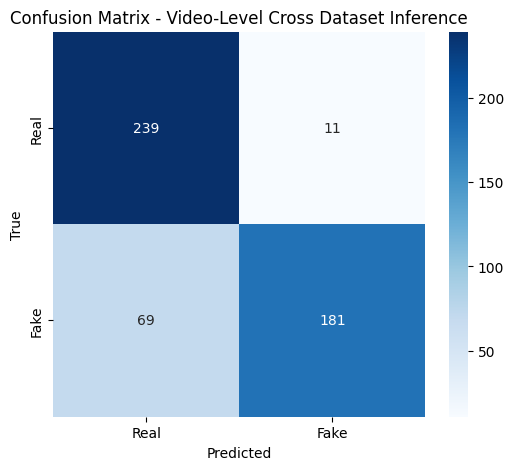

In [ ]:
# === VIDEO-LEVEL INFERENCE ON CROSS-DATASET (REAL + FAKE) ===
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
from pathlib import Path
import glob
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from collections import defaultdict
from google.colab import drive
import numpy as np

# --- Mount Drive ---
drive.mount('/content/drive', force_remount=True)

# --- Config ---
SAVED_MODEL_PATH = "/content/drive/MyDrive/final_balanced_data/cnn_lstm30_output/best_model.pth"

# Separate zips
FINAL_REAL_FRAMES_ZIP = "/content/drive/MyDrive/Test_Dataset/Real/Frames_Real.zip"
FINAL_FAKE_FRAMES_ZIP = "/content/drive/MyDrive/Test_Dataset/Fake/Frames_Fake.zip"
FINAL_REAL_FLOW_ZIP   = "/content/drive/MyDrive/Test_Dataset/Real/Flow_Real.zip"
FINAL_FAKE_FLOW_ZIP   = "/content/drive/MyDrive/Test_Dataset/Fake/Flow_Fake.zip"

# Local unzip dirs
FRAMES_BASE_DIR = "/content/Frames"
FLOW_BASE_DIR   = "/content/Flow"

LSTM_HIDDEN_DIM = 128
FLOW_DIM = 2
NUM_CLASSES = 2
DROPOUT_RATE = 0.6
SEQ_LENGTH = 30
INFERENCE_STEP_SIZE = SEQ_LENGTH // 2  # 50% overlap
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Helper: unzip ---
def unzip_to_dir(zip_path, extract_dir):
    os.makedirs(extract_dir, exist_ok=True)
    if len(os.listdir(extract_dir)) == 0:
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(extract_dir)
        print(f"✅ Extracted {zip_path} -> {extract_dir}")
    else:
        print(f"ℹ️ Using existing extracted folder: {extract_dir}")

# Unzip frames and flow
unzip_to_dir(FINAL_REAL_FRAMES_ZIP, os.path.join(FRAMES_BASE_DIR, "Real"))
unzip_to_dir(FINAL_FAKE_FRAMES_ZIP, os.path.join(FRAMES_BASE_DIR, "Fake"))
unzip_to_dir(FINAL_REAL_FLOW_ZIP,   os.path.join(FLOW_BASE_DIR, "Real"))
unzip_to_dir(FINAL_FAKE_FLOW_ZIP,   os.path.join(FLOW_BASE_DIR, "Fake"))

# --- Image Transform ---
IMG_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Model Definition ---
class DeepfakeDetectionModel(nn.Module):
    def __init__(self, cnn_output_dim=512, lstm_hidden_dim=LSTM_HIDDEN_DIM, lstm_layers=1,
                 flow_dim=FLOW_DIM, num_classes=NUM_CLASSES, dropout_rate=DROPOUT_RATE, freeze_cnn_layers=False):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.cnn_backbone = nn.Sequential(*list(resnet.children())[:-1])
        if freeze_cnn_layers:
            layers_to_freeze_idx = 7
            for i, child in enumerate(self.cnn_backbone.children()):
                if i < layers_to_freeze_idx:
                    for param in child.parameters():
                        param.requires_grad = False

        self.cnn_output_dim = resnet.fc.in_features
        self.lstm = nn.LSTM(input_size=self.cnn_output_dim, hidden_size=lstm_hidden_dim,
                            num_layers=lstm_layers, batch_first=True,
                            dropout=dropout_rate if lstm_layers > 1 else 0)
        pooled_dim = 2 * lstm_hidden_dim
        self.classifier_with_flow = nn.Sequential(
            nn.Linear(pooled_dim + flow_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )
        self.classifier_no_flow = nn.Sequential(
            nn.Linear(pooled_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, frames, flow_features_sequence):
        batch_size, seq_len, _, _, _ = frames.size()
        cnn_features_list = []
        for t in range(seq_len):
            frame_input = frames[:, t, :, :, :]
            feat = self.cnn_backbone(frame_input)
            feat = feat.view(batch_size, -1)
            cnn_features_list.append(feat)
        cnn_sequence_features = torch.stack(cnn_features_list, dim=1)

        lstm_out, _ = self.lstm(cnn_sequence_features)
        lstm_mean = torch.mean(lstm_out, dim=1)
        lstm_max = torch.max(lstm_out, dim=1).values
        lstm_features = torch.cat((lstm_mean, lstm_max), dim=1)

        if flow_features_sequence is not None and \
           flow_features_sequence.ndim == 3 and \
           flow_features_sequence.shape[1] == seq_len:
            aggregated_flow_features = torch.mean(flow_features_sequence, dim=1)
            combined_features = torch.cat((lstm_features, aggregated_flow_features), dim=1)
            return self.classifier_with_flow(combined_features)
        else:
            return self.classifier_no_flow(lstm_features)

# --- Load Model ---
model = DeepfakeDetectionModel().to(DEVICE)
model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=DEVICE))
model.eval()
print("✅ Model loaded successfully.")

# --- Helper: Load sequence of frames ---
def load_frame_sequence(frame_paths):
    imgs = [IMG_TRANSFORM(Image.open(p).convert("RGB")) for p in frame_paths]
    return torch.stack(imgs)

# --- Collect sequences with overlapping ---
def collect_sequences(label):
    frame_dirs = sorted(glob.glob(os.path.join(FRAMES_BASE_DIR, label, "*")))
    sequences = defaultdict(list)
    for vid_dir in frame_dirs:
        vid_name = Path(vid_dir).stem
        frame_paths = sorted(glob.glob(os.path.join(vid_dir, "*.jpg")))
        for seq_idx in range(0, len(frame_paths) - SEQ_LENGTH + 1, INFERENCE_STEP_SIZE):
            seq_frames = frame_paths[seq_idx: seq_idx + SEQ_LENGTH]
            if len(seq_frames) == SEQ_LENGTH:
                flow_name = f"{label.lower()}_{vid_name}_seq{seq_idx//INFERENCE_STEP_SIZE}.pt"
                flow_path = os.path.join(FLOW_BASE_DIR, label, flow_name)
                if os.path.exists(flow_path):
                    sequences[vid_name].append((seq_frames, flow_path, 0 if label=="Real" else 1))
    return sequences

print("📂 Collecting sequences...")
real_sequences = collect_sequences("Real")
fake_sequences = collect_sequences("Fake")

# --- Hybrid decision rule ---
def hybrid_video_decision(seq_outputs, avg_threshold=0.45, seq_threshold=0.55):
    """
    seq_outputs: list of raw logits from model for each sequence
    avg_threshold: threshold on average fake probability
    seq_threshold: threshold for any single sequence
    """
    probs_list = [torch.softmax(out, dim=1).squeeze().cpu().numpy() for out in seq_outputs]
    fake_probs = [p[1] for p in probs_list]

    avg_fake = np.mean(fake_probs)
    any_fake = any(p >= seq_threshold for p in fake_probs)

    if avg_fake >= avg_threshold or any_fake:
        return 1  # Fake
    else:
        return 0  # Real

# --- Run inference ---
y_true, y_pred = [], []
with torch.no_grad():
    for vid_dict, label_name in [(real_sequences, "Real"), (fake_sequences, "Fake")]:
        for vid_name, seq_list in vid_dict.items():
            true_label = 0 if label_name == "Real" else 1
            seq_outputs = []
            for frame_paths, flow_path, _ in seq_list:
                frames_tensor = load_frame_sequence(frame_paths).unsqueeze(0).to(DEVICE)
                flow_tensor = torch.load(flow_path).unsqueeze(0).to(DEVICE)
                outputs = model(frames_tensor, flow_tensor)
                seq_outputs.append(outputs)
            if seq_outputs:
                final_pred = hybrid_video_decision(seq_outputs, avg_threshold=0.4, seq_threshold=0.6)
                y_true.append(true_label)
                y_pred.append(final_pred)

# --- Metrics ---
print("\n--- FINAL EVALUATION RESULTS ---")
acc = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {acc:.4f} ({acc:.2%})")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real","Fake"], yticklabels=["Real","Fake"])
plt.title("Confusion Matrix - Video-Level Cross Dataset Inference")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Testing on Unknown Video

In [ ]:
# === SINGLE VIDEO UPLOAD + ON-THE-FLY INFERENCE (ALL FRAMES, SEQ=30) ===
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import cv2
import numpy as np
from google.colab import drive, files

# --- Config ---
SAVED_MODEL_PATH = "/content/drive/MyDrive/final_balanced_data/cnn_lstm30_output/best_model.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEQ_LENGTH = 30
LSTM_HIDDEN_DIM = 128
FLOW_DIM = 2
NUM_CLASSES = 2
DROPOUT_RATE = 0.6
OVERLAP = 15  # frames overlap between sequences
IMG_TRANSFORM = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# --- Model definition ---
class DeepfakeDetectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.cnn_backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.cnn_output_dim = resnet.fc.in_features
        self.lstm = nn.LSTM(input_size=self.cnn_output_dim, hidden_size=LSTM_HIDDEN_DIM,
                            batch_first=True)
        pooled_dim = 2 * LSTM_HIDDEN_DIM
        self.classifier_with_flow = nn.Sequential(
            nn.Linear(pooled_dim + FLOW_DIM, 128),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),
            nn.Linear(128, NUM_CLASSES)
        )
        self.classifier_no_flow = nn.Sequential(
            nn.Linear(pooled_dim, 128),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),
            nn.Linear(128, NUM_CLASSES)
        )

    def forward(self, frames, flow_features_sequence=None):
        batch_size, seq_len, _, _, _ = frames.size()
        cnn_feats = []
        for t in range(seq_len):
            x = frames[:, t]
            feat = self.cnn_backbone(x)
            feat = feat.view(batch_size, -1)
            cnn_feats.append(feat)
        cnn_sequence = torch.stack(cnn_feats, dim=1)
        lstm_out, _ = self.lstm(cnn_sequence)
        lstm_mean = torch.mean(lstm_out, dim=1)
        lstm_max = torch.max(lstm_out, dim=1).values
        lstm_feat = torch.cat([lstm_mean, lstm_max], dim=1)
        if flow_features_sequence is not None:
            aggregated_flow = torch.mean(flow_features_sequence, dim=1)
            combined = torch.cat([lstm_feat, aggregated_flow], dim=1)
            return self.classifier_with_flow(combined)
        else:
            return self.classifier_no_flow(lstm_feat)

# --- Load model ---
model = DeepfakeDetectionModel().to(DEVICE)
model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=DEVICE))
model.eval()
print("✅ Model loaded successfully.")

# --- Optical flow ---
def compute_optical_flow(frames):
    flows = [np.array([0.0, 0.0], dtype=np.float32)]
    for i in range(len(frames)-1):
        prev_gray = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
        next_gray = cv2.cvtColor(frames[i+1], cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None,
                                            0.5, 3, 15, 3, 5, 1.2, 0)
        mag = np.sqrt(flow[...,0]**2 + flow[...,1]**2)
        flows.append(np.array([np.mean(mag), np.var(mag)], dtype=np.float32))
    return torch.tensor(np.array(flows), dtype=torch.float32).unsqueeze(0)

# --- Frames -> Tensor ---
def frames_to_tensor(frames_seq):
    imgs = [IMG_TRANSFORM(Image.fromarray(cv2.cvtColor(f, cv2.COLOR_BGR2RGB))) for f in frames_seq]
    return torch.stack(imgs).unsqueeze(0)

# --- Video inference ---
def predict_video(video_path, seq_length=SEQ_LENGTH, overlap=OVERLAP):
    cap = cv2.VideoCapture(video_path)
    frames = [f for ret, f in iter(lambda: cap.read(), (False, None))]
    cap.release()
    if len(frames) < seq_length:
        frames += [frames[-1]] * (seq_length - len(frames))

    # Create overlapping sequences
    sequences = []
    step = seq_length - overlap
    for start in range(0, len(frames) - seq_length + 1, step):
        sequences.append(frames[start:start+seq_length])

    seq_preds = []
    with torch.no_grad():
        for seq in sequences:
            frames_tensor = frames_to_tensor(seq).to(DEVICE)
            flow_tensor = compute_optical_flow(seq).to(DEVICE)
            out = model(frames_tensor, flow_tensor)
            probs = torch.softmax(out, dim=1).squeeze().cpu().numpy()
            seq_preds.append(int(np.argmax(probs)))

    # Video-level prediction: majority vote
    final_pred = max(set(seq_preds), key=seq_preds.count)
    return final_pred, seq_preds

# --- Mount Drive & Upload ---
drive.mount('/content/drive', force_remount=True)
uploaded = files.upload()
video_file = list(uploaded.keys())[0]

# --- Predict ---
label, seqs = predict_video(video_file)
print(f"Predicted class: {label} (0=Real, 1=Fake)")
print(f"Sequence-level predictions: {seqs}")


✅ Model loaded successfully.
Mounted at /content/drive


Saving 1 (12).mp4 to 1 (12).mp4
Predicted class: 0 (0=Real, 1=Fake)
Sequence-level predictions: [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
